# 音の情報処理1：音の表現（入力・再生・可視化）


第3回で必ず演習してきていただきたいのは以下の４つです。   
ちょっとうんざりするかもしれませんが、実行だけはしてきてください。

- SoundProcessing1.ipynb
- SoundProcessing2.ipynb
- SoundProcessing3.ipynb
- SoundProcessing4.ipynb

また、発展的演習は以下の1つです。  

- MFCC.ipynb：MFCCをつかって音声や楽器の違いを聞き分けよう


## 1  音ファイル
### 1.1 音ファイルの読み込み
音のファイルを読み込んで再生しましょう。  
まずはファイルを読み込みます。
このnotebookがおかれているフォルダの下に'sounds'という名前のフォルダがあります。その中に'Violin-music.wav'という音声を用意しています。  
これは、ヴァイオリンの独奏を収録したものです。   

In [2]:
import wave
wavfile = wave.open('sounds/Violin-music.wav', 'rb')

### 1.2 音ファイルのパラメータ
拡張子がwavとなっている場合、これは「RIFF waveform Audio Format」という音声ファイルフォーマットという形式で記録されています。   
このフォーマットは非圧縮です（たとえばmp3などは人間の耳では聞き取れない高周波帯域の音情報を除去している圧縮音響フォーマットです）が、  
ファイルの冒頭（ヘッダ）に、この音ファイルに関する様々なパラメータが記録されています。  

どのようなパラメータが記録されているかは以下のプログラムで読み取ることができます。

In [3]:
# WAVファイルに記録されている情報の表示
print("Channel num : ", wavfile.getnchannels()) # モノラルならば1, ステレオなら2
print("Sample size : ", wavfile.getsampwidth()) # 音声データ1サンプルあたりのバイト数。ビット深度とも呼ぶ。2なら2-bytes(16-bit), 3なら3-byte(24-bit)など
print("Sampling rate : ", wavfile.getframerate()) # サンプリングレート。1秒当たり何回データを記録するか
print("Frame num : ", wavfile.getnframes()) # このファイルのフレーム数
print("Sec : ", float(wavfile.getnframes()) / wavfile.getframerate()) # フレーム数/サンプリングレート=録音時間
print("Prams : ", wavfile.getparams()) # このファイルに記録されている各種パラメータを一気に出力

Channel num :  1
Sample size :  2
Sampling rate :  48000
Frame num :  536465
Sec :  11.176354166666666
Prams :  _wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=536465, comptype='NONE', compname='not compressed')


### 1.3 音声ファイルの再生（オプション）
PyAudioというライブラリを使って音を再生しましょう。  
これにはまずオーディオストリームを生成しなければいけません。
音を実際に再生するためには、ファイルから音情報をメモリに読み込み、それを波形（実際には電流）に変換してスピーカやイヤホンに送電しますが、
音声データはサイズが非常に大きかったり、時にはサイズが決まっていない（音声情報を生成しながら再生する場合など）ことがありますので、
ファイルを一気に最後まで読み込むのではなく、先頭から小分けにして読み込みます。  
このときの小分けのサイズをチャンク、それが読み込まれている場所をバッファと呼びます。  

このファイルは1サンプルあたり16bit=2byteで記録されていましたね。  
例えば、チャンクサイズが1024なら、536465フレームの音声ファイルを1024フレーム=2048bitずつに切り分けてバッファに読み込んで順に再生していくことになります。  
1024フレームを再生し終えるまでに次の音声ファイルの読み込みが間に合わなければ、音が途切れることになります。  
何チャンク分になるか数えて見ましょう。コード中でnumという変数で数えています。  
このファイルは536465フレームですから、536465/1024=523あまり913ということで、523回目で913フレーム×2byte=1826byteを読み込んで終了しています。
### チャンクサイズを小さくするとどうなるか試してみましょう。例えば1024-->16フレームにするとどうなりますか？

In [ ]:
####################################################
####################################################
####################################################
####################################################
######## 音が出るので注意してください！！！！ ######
####################################################
####################################################
####################################################
####################################################
####################################################

import pyaudio

# wavファイルを読み込み
wavfile = wave.open('sounds/Violin-music.wav', 'rb')

# PyAudioのインスタンスを生成
p = pyaudio.PyAudio()

# Streamを生成
stream = p.open(format=p.get_format_from_width(wavfile.getsampwidth()),
                channels=wavfile.getnchannels(),
                rate=wavfile.getframerate(),
                output=True)
# チャンク単位でストリームに出力し音声を再生
chunk = 1024

data = wavfile.readframes(chunk) # wavfileからdataに1つ目のチャンク1024フレームを取ってくる
num = 1
while len(data) > 0: # wavfileをすべて読み込み終わったら終わり
    stream.write(data) # dataをバッファに送る（1024フレーム×1チャンネル×2byte=2048byte
    data = wavfile.readframes(chunk) # wavfileから次のチャンクを取ってくる
    print(num, ": len(data)=", len(data))
    num+=1
    
stream.stop_stream()
stream.close()
p.terminate()

## 2. 音波形の描画

### 2.1 波形のデータ変換とグラフ化

音の波形をグラフとして描画してみましょう。  
この時、横軸を時間にするためにはどうしたらいいでしょうか？   
上で書いた通り、この音声波形が1秒間に何回サンプリングされたかは、`wavfile.getframerate()`で知ることができました。  
よって、x軸は、そのデータのインデックスを` wavfile.getframerate()`で割った値をラベルにしてあげればいいということになりますね。

duration:  536465


<IPython.core.display.Javascript object>


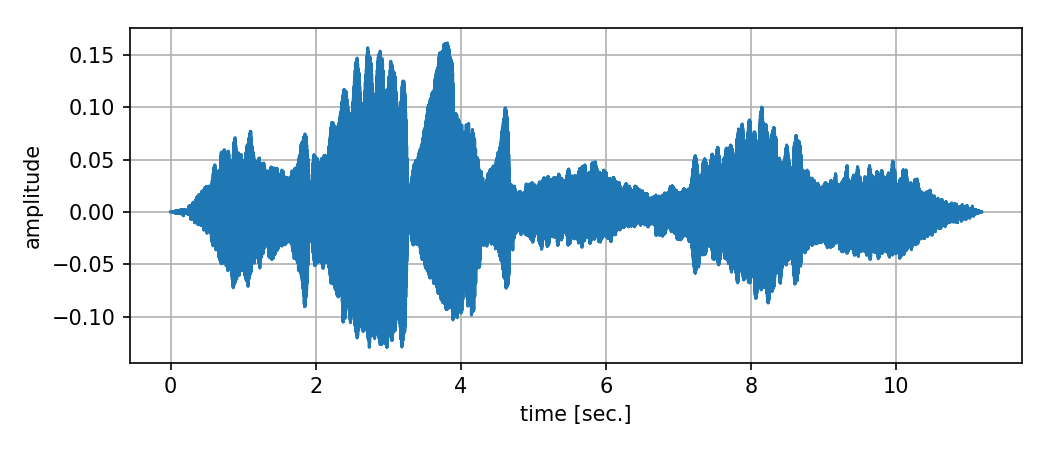

In [6]:
%matplotlib notebook

import wave
import numpy as np
import matplotlib.pyplot as plt

wavfile = wave.open("sounds/Violin-music.wav" , "rb" ) # オーディオファイルを開く
# wavfileのデータを最後まで一気に読み込む
#（データサイズが大きいファイルを読み込むときは、読み込むサイズを指定しないとPCがフリーズします！）
data = wavfile.readframes(wavfile.getnframes())
sampling_rate = wavfile.getframerate()  # フレームレート[1/s]
sample_size = wavfile.getsampwidth() # 1サンプルあたりのサイズ
# wavfileをクローズしておく
wavfile.close()

# バイナリデータをint型に変換
data = np.frombuffer(data, dtype= "int16") 

# 1サンプルあたりsample_sizeバイトで表されているということは、
# 表現可能な階調は2の(8byte x sample_size)乗
# ただし、波形は正と負があるため、正・負それぞれはの領域は、その1/2階調の細かさまで表現できる
# これを最大値として正規化
amp  = 2**(8 * sample_size) / 2
data = data/amp
print('duration: ', len(data))

# X軸をサンプル数から経過時間にするため、X軸の座標を生成
# このデータは0秒からlen(data)/sampling_rate秒まである
# 隣り合うデータとの時間幅は、1.0/sampling_rate秒
x = np.arange(0, len(data)/sampling_rate, 1.0/sampling_rate)

# 波形を描画
fig = plt.figure(figsize=(7, 3)) # figure(図を配置する画面)のサイズを指定
ax = plt.subplot() # figureには複数の図を配置できるので、そのうち図を1つ描画する空間を準備

ax.plot(x, data)
ax.set_xlabel("time [sec.]")
ax.set_ylabel("amplitude")
ax.grid()
fig.tight_layout() # 図がはみ出さないようにレイアウト
plt.savefig('fig/SoundProcessing1-1.png') # 図を画像として保存

### 2.2 波形の拡大
先ほどの波形を拡大してみましょう。  
連続的な波のように見える波形は、拡大すると離散的な値のつながりであることが分かります。

<IPython.core.display.Javascript object>


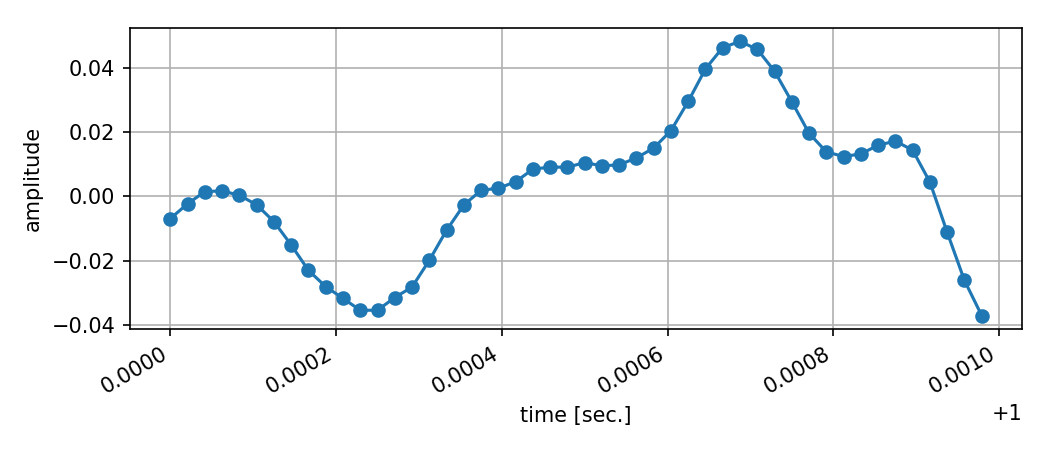

In [7]:
# 波形を描画
start = 1.0 # 開始から60秒後を起点とする
duration = 0.001 # 1ミリ秒分を描画

fig = plt.figure(figsize=(7, 3)) # figure(図を配置する画面)のサイズを指定
ax = plt.subplot() # figureには複数の図を配置できるので、そのうち図を1つ描画する空間を準備

ax.plot(x[round(start*sampling_rate):round(start*sampling_rate+duration*sampling_rate)], 
        data[round(start*sampling_rate):round(start*sampling_rate+duration*sampling_rate)], marker="o")

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')# 軸を右揃えにして斜めに
ax.grid() # グリッド線を描画
ax.set_xlabel("time [sec.]") # X軸のラベル
ax.set_ylabel("amplitude") # Y軸のラベル
fig.tight_layout() # 図がはみ出さないようにレイアウト
plt.savefig('fig/SoundProcessing1-2.png') # 図を画像として保存

## 3. Pythonによる音の収録
マイクロフォンを内蔵したPCや、マイク入力端子を持つPCであれば、音の収録もPyAudioで行うことができます。  
しかし、音の収録環境はよく考えて用意してください。  
ノートパソコンに内蔵されているマイクや、USBマイク等で収録した音声は、人間が聞き取るうえでは問題ないことも多いですが、
マイク自体やサウンドチップ上で発生したノイズが入り込んでいたり、高周波を除去するなど様々な圧縮が加えられ、
精密な処理に適さない音であることが多いです。音声認識精度も概ね低下します。  
分析したい内容（指向性、周波数帯等）に合わせて、計測用のマイクロフォンを選定する、オーディオインタフェースを用意する等を検討してください。